In [2]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Read the pickle file
with open("../tracker_stubs/ball_detections.pkl", "rb") as f:
    ball_positions = pickle.load(f)

In [4]:
# Get bounding box coordinates otherwise empty list
ball_positions = [x.get(1, []) for x in ball_positions]

# Convert list into a pandas dataframe
# Empty lists become NaN
df_ball_positions = pd.DataFrame(ball_positions, columns=["x1", "y1", "x2", "y2"])

# Interpolate missing values and backfill where start
# of sequence is missing (unable to interpolate)
df_ball_positions = df_ball_positions.interpolate()
df_ball_positions = df_ball_positions.bfill()

In [5]:
# Creates a new mid_y column and mid_y_rolling_mean column
df_ball_positions["mid_y"] = (df_ball_positions["y1"] + df_ball_positions["y2"]) / 2
df_ball_positions["mid_y_rolling_mean"] = df_ball_positions["mid_y"].rolling(window=5, min_periods=1, center=False).mean()

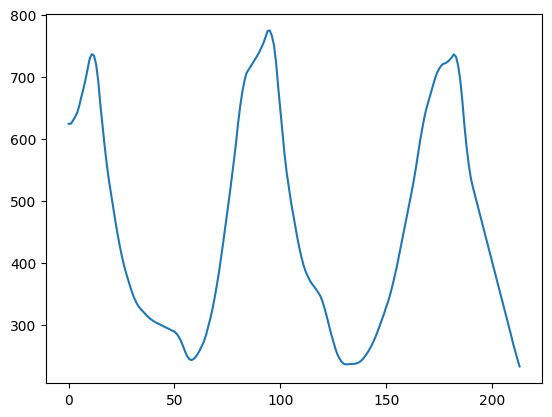

In [6]:
# Plot the mid_y rolling mean
plt.plot(df_ball_positions["mid_y_rolling_mean"])

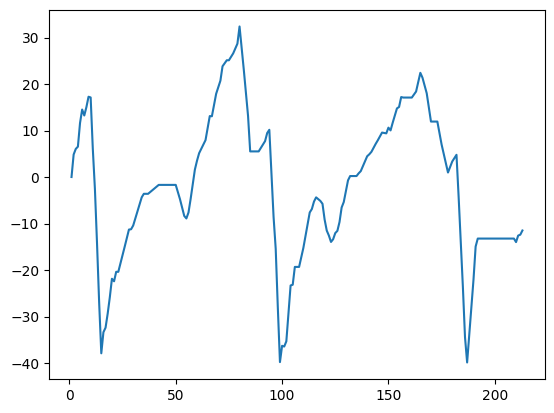

In [7]:
# Calculates by taking difference of mid_y_rolling_mean between 2 consecutive rows
df_ball_positions["delta_y"] = df_ball_positions["mid_y_rolling_mean"].diff()
plt.plot(df_ball_positions["delta_y"])

In [8]:
# All frames are initially set to 0 ball hits
df_ball_positions["ball_hit"] = 0

# Sets minimum threshold to determine a hit
minimum_frames_for_hit = 25

# 1.2 * minimum_frames_for_hit sets a buffer so 25 frames of the
# 30 frame sequence need to confirm a hit, gives room for inconsistencies
for i in range(1, len(df_ball_positions) - int(1.2 * minimum_frames_for_hit)):
    negative_pos_change = df_ball_positions["delta_y"].iloc[i] > 0 and df_ball_positions["delta_y"].iloc[i + 1] < 0
    positive_pos_change = df_ball_positions["delta_y"].iloc[i] < 0 and df_ball_positions["delta_y"].iloc[i + 1] > 0

    if negative_pos_change or positive_pos_change:
        frame_count = 0

        # Compares the next 30 frames to the original ith frame
        for j in range(i + 1, i + 1 + int(1.2 * minimum_frames_for_hit)):
            negative_pos_change_after = df_ball_positions["delta_y"].iloc[i] > 0 and df_ball_positions["delta_y"].iloc[j] < 0
            positive_pos_change_after = df_ball_positions["delta_y"].iloc[i] < 0 and df_ball_positions["delta_y"].iloc[j] > 0

            if negative_pos_change and negative_pos_change_after or positive_pos_change and positive_pos_change_after:
                frame_count += 1

        if frame_count >= minimum_frames_for_hit:
            df_ball_positions.loc[i, "ball_hit"] = 1

In [9]:
# This is manually grabbing the specific frames where there was a ball hit
# Need to come up with a better solution later
df_ball_positions[df_ball_positions["ball_hit"] == 1]
frames_with_ball_hits = df_ball_positions[df_ball_positions["ball_hit"] == 1].index.tolist()

### All this code is basically pasted into the BallTracker class for the get_ball_hit_frames method
#### Just wanted to help visualize the dataframe